[*********************100%%**********************]  1 of 1 completed


BSM Implied Volatility:  0.3


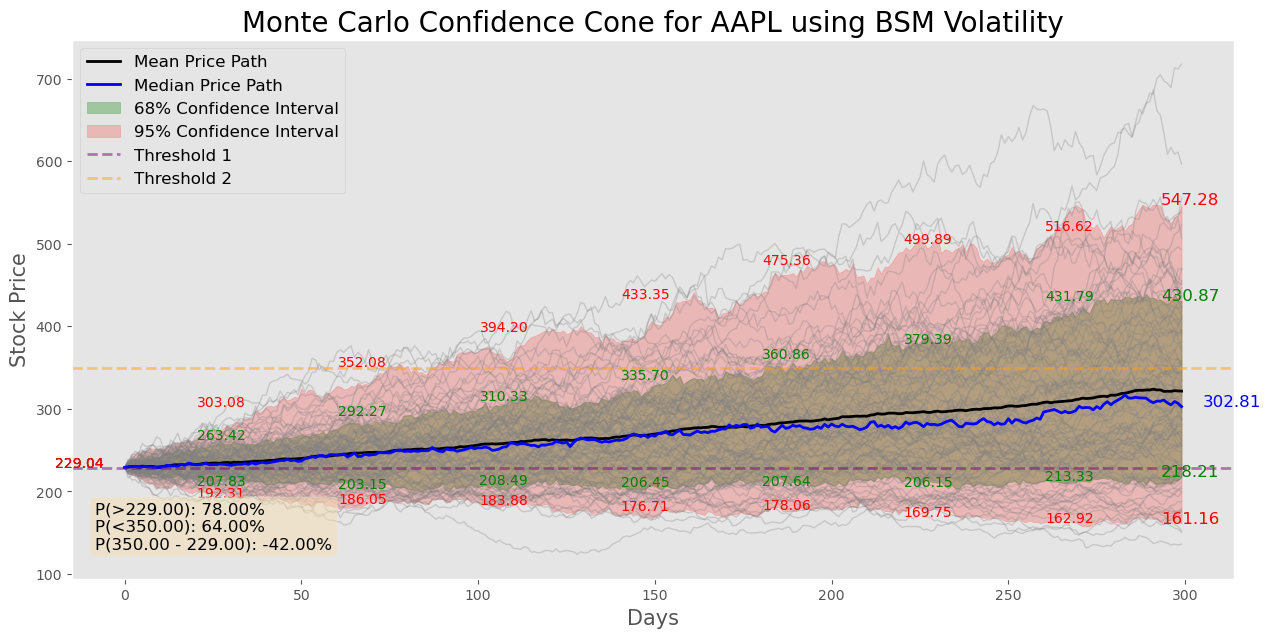

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm
plt.style.use('ggplot')  

def monte_carlo(ticker, prediction_days, number_simulations,BSM=0.26,threshold1=None,threshold2=None):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365) #Used to set a 1 yr period
    df = yf.download(ticker, start=start_date, end=end_date) 
    log_returns = np.log(df['Close'] / df['Close'].shift(1)) #Log returns
    days_to_forecast = prediction_days
    num_simulations = number_simulations
    dt = 1  # 1 trading day
    if threshold2 is None:
        threshold2 = df['Adj Close'][-1]*1.9
    if threshold1 is None:
        threshold1 = df['Adj Close'][-1]*0.5

    volatility_bsm =BSM  # Assuming 26% annualized volatility
    print("BSM Implied Volatility: ", volatility_bsm)
    def run_simulation(volatility, dt, annualized=False):
        simulated_prices = np.zeros((days_to_forecast, num_simulations))
        simulated_prices[0] = df['Close'][-1]
        if annualized:
            volatility = volatility / np.sqrt(252)
        for t in range(1, days_to_forecast):
            random_walk = np.random.normal(loc=log_returns.mean() * dt,
                                           scale=volatility * np.sqrt(dt),
                                           size=num_simulations)
            simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_walk)
        return simulated_prices

    simulated_prices_bsm = run_simulation(volatility_bsm, dt, annualized=True)
    fig, ax = plt.subplots(figsize=(15, 7))
    mean_price_path = np.mean(simulated_prices_bsm, axis=1)
    median_price_path = np.median(simulated_prices_bsm, axis=1)
    lower_bound_68 = np.percentile(simulated_prices_bsm, 16, axis=1)
    upper_bound_68 = np.percentile(simulated_prices_bsm, 84, axis=1)
    lower_bound_95 = np.percentile(simulated_prices_bsm, 2.5, axis=1)
    upper_bound_95 = np.percentile(simulated_prices_bsm, 97.5, axis=1)
    ax.plot(simulated_prices_bsm, color='gray', alpha=0.3, linewidth=1) # This is the plot for the randomised samples
    ax.plot(mean_price_path, color='black', label='Mean Price Path', linewidth=2) #MEan path plot
    ax.plot(median_price_path, color='blue', label='Median Price Path', linewidth=2)#Median
    ax.fill_between(range(days_to_forecast), lower_bound_68, upper_bound_68, color='green', alpha=0.3, label='68% Confidence Interval')
    ax.fill_between(range(days_to_forecast), lower_bound_95, upper_bound_95, color='red', alpha=0.2, label='95% Confidence Interval')
    ax.axhline(y=threshold1, color='purple', linestyle='--', alpha=0.5, label='Threshold 1', linewidth=2)
    ax.axhline(y=threshold2, color='orange', linestyle='--', alpha=0.5, label='Threshold 2', linewidth=2)
    ax.set_xlabel('Days', fontsize=15)
    ax.set_ylabel('Stock Price', fontsize=15)
    ax.set_title(f'Monte Carlo Confidence Cone for {ticker} using BSM Volatility', fontsize=20)
    ax.legend(fontsize=12)
    ax.grid(False)

    for day in range(0, days_to_forecast, 40): #Price estimation every 40 days:
        ax.annotate(f'{lower_bound_68[day]:.2f}', xy=(day, lower_bound_68[day]), xycoords='data', #MOre plot stuff
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{upper_bound_68[day]:.2f}', xy=(day, upper_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{lower_bound_95[day]:.2f}', xy=(day, lower_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)
        ax.annotate(f'{upper_bound_95[day]:.2f}', xy=(day, upper_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)

    above_threshold1_prob = (simulated_prices_bsm[-1] > threshold1).sum() / num_simulations #Probabilty of  staying in certin regions in accordance to our defined thresholds
    below_threshold2_prob = (simulated_prices_bsm[-1] < threshold2).sum() / num_simulations
    between_thresholds_prob = 1 - above_threshold1_prob - below_threshold2_prob

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5) #Our box displaying those probabilities
    ax.text(0.02, 0.05, f'P(>{threshold1:.2f}): {above_threshold1_prob:.2%}\n'
                        f'P(<{threshold2:.2f}): {below_threshold2_prob:.2%}\n'
                        f'P({threshold2:.2f} - {threshold1:.2f}): {between_thresholds_prob:.2%}',
            transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    ax.annotate(f'{median_price_path[-1]:.2f}', xy=(days_to_forecast - 1, median_price_path[-1]), xycoords='data', #More plots
                xytext=(15, 0), textcoords='offset points', color='blue', fontsize=12)
    ax.annotate(f'{lower_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{upper_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{lower_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)
    ax.annotate(f'{upper_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)
    plt.show()


monte_carlo('AAPL', 300, 100,BSM=0.3,threshold1=229,threshold2=350) #Calling our function

[*********************100%%**********************]  1 of 1 completed


BSM Implied Volatility:  0.3


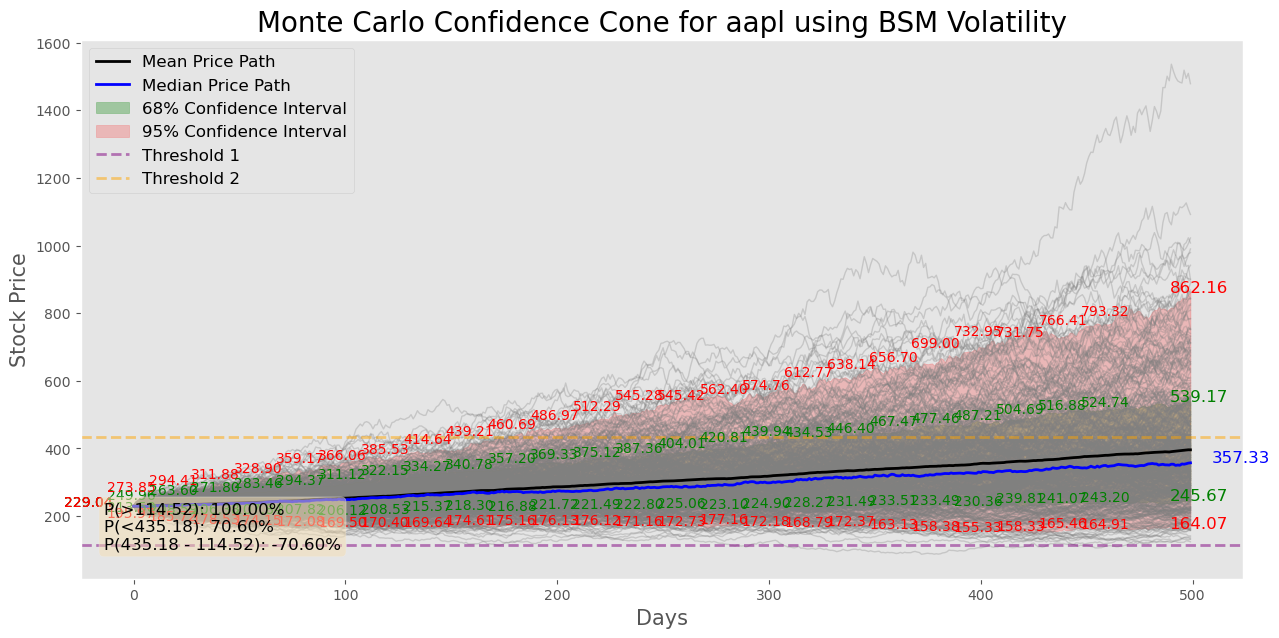

: 

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

plt.style.use('ggplot')

def monte_carlo(ticker, prediction_days, number_simulations, BSM=0.26, threshold1=None, threshold2=None):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    df = yf.download(ticker, start=start_date, end=end_date)
    log_returns = np.log(df['Close'] / df['Close'].shift(1))
    days_to_forecast = prediction_days
    num_simulations = number_simulations
    dt = 1
    if threshold2 is None:
        threshold2 = df['Adj Close'][-1] * 1.9
    if threshold1 is None:
        threshold1 = df['Adj Close'][-1] * 0.5

    volatility_bsm = BSM
    print("BSM Implied Volatility: ", volatility_bsm)

    def run_simulation(volatility, dt, annualized=False):
        simulated_prices = np.zeros((days_to_forecast, num_simulations))
        simulated_prices[0] = df['Close'][-1]

        if annualized:
            volatility = volatility / np.sqrt(252)

        for t in range(1, days_to_forecast):
            random_walk = np.random.normal(loc=log_returns.mean() * dt,
                                           scale=volatility * np.sqrt(dt),
                                           size=num_simulations)
            simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_walk)
        return simulated_prices

    simulated_prices_bsm = run_simulation(volatility_bsm, dt, annualized=True)

    fig, ax = plt.subplots(figsize=(15, 7))

    mean_price_path = np.mean(simulated_prices_bsm, axis=1)
    median_price_path = np.median(simulated_prices_bsm, axis=1)
    lower_bound_68 = np.percentile(simulated_prices_bsm, 16, axis=1)
    upper_bound_68 = np.percentile(simulated_prices_bsm, 84, axis=1)
    lower_bound_95 = np.percentile(simulated_prices_bsm, 2.5, axis=1)
    upper_bound_95 = np.percentile(simulated_prices_bsm, 97.5, axis=1)

    # Plot the chaotic lines with more prominence
    ax.plot(simulated_prices_bsm, color='gray', alpha=0.3, linewidth=1)

    # Plot the mean and median price paths
    ax.plot(mean_price_path, color='black', label='Mean Price Path', linewidth=2)
    ax.plot(median_price_path, color='blue', label='Median Price Path', linewidth=2)

    # Plot the confidence intervals as shaded areas
    ax.fill_between(range(days_to_forecast), lower_bound_68, upper_bound_68, color='green', alpha=0.3, label='68% Confidence Interval')
    ax.fill_between(range(days_to_forecast), lower_bound_95, upper_bound_95, color='red', alpha=0.2, label='95% Confidence Interval')

    # Plot the thresholds
    ax.axhline(y=threshold1, color='purple', linestyle='--', alpha=0.5, label='Threshold 1', linewidth=2)
    ax.axhline(y=threshold2, color='orange', linestyle='--', alpha=0.5, label='Threshold 2', linewidth=2)

    # Set labels and title
    ax.set_xlabel('Days', fontsize=15)
    ax.set_ylabel('Stock Price', fontsize=15)
    ax.set_title(f'Monte Carlo Confidence Cone for {ticker} using BSM Volatility', fontsize=20)
    ax.legend(fontsize=12)

    # Remove the grid
    ax.grid(False)

    # Price estimates every 20 days
    for day in range(0, days_to_forecast, 20):
        ax.annotate(f'{lower_bound_68[day]:.2f}', xy=(day, lower_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{upper_bound_68[day]:.2f}', xy=(day, upper_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green', fontsize=10)
        ax.annotate(f'{lower_bound_95[day]:.2f}', xy=(day, lower_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)
        ax.annotate(f'{upper_bound_95[day]:.2f}', xy=(day, upper_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red', fontsize=10)

    above_threshold1_prob = (simulated_prices_bsm[-1] > threshold1).sum() / num_simulations
    below_threshold2_prob = (simulated_prices_bsm[-1] < threshold2).sum() / num_simulations
    between_thresholds_prob = 1 - above_threshold1_prob - below_threshold2_prob

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.05, f'P(>{threshold1:.2f}): {above_threshold1_prob:.2%}\n'
                        f'P(<{threshold2:.2f}): {below_threshold2_prob:.2%}\n'
                        f'P({threshold2:.2f} - {threshold1:.2f}): {between_thresholds_prob:.2%}',
            transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    ax.annotate(f'{median_price_path[-1]:.2f}', xy=(days_to_forecast - 1, median_price_path[-1]), xycoords='data',
                xytext=(15, 0), textcoords='offset points', color='blue', fontsize=12)
    ax.annotate(f'{lower_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{upper_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green', fontsize=12)
    ax.annotate(f'{lower_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)
    ax.annotate(f'{upper_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red', fontsize=12)

    return fig

def run_simulation():
    ticker = ticker_entry.get()
    prediction_days = int(prediction_days_entry.get()) 
    number_simulations = int(number_simulations_entry.get()) 
    BSM = float(BSM_entry.get()) 
    threshold1 = float(threshold1_entry.get()) if threshold1_entry.get() else None
    threshold2 = float(threshold2_entry.get()) if threshold2_entry.get() else None

    fig = monte_carlo(ticker, prediction_days, number_simulations, BSM, threshold1, threshold2)
    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()
    canvas.get_tk_widget().grid(row=7, column=0, columnspan=2, sticky=(tk.W, tk.E, tk.N, tk.S))

window = tk.Tk()
window.title("Monte Carlo Simulation")

frame = ttk.Frame(window, padding="10")
frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

ttk.Label(frame, text="Ticker:").grid(row=0, column=0, sticky=tk.W)
ticker_entry = ttk.Entry(frame)
ticker_entry.grid(row=0, column=1, sticky=(tk.W, tk.E))

ttk.Label(frame, text="Prediction Days:").grid(row=1, column=0, sticky=tk.W)
prediction_days_entry = ttk.Entry(frame)
prediction_days_entry.grid(row=1, column=1, sticky=(tk.W, tk.E))

ttk.Label(frame, text="Number of Simulations:").grid(row=2, column=0, sticky=tk.W)
number_simulations_entry = ttk.Entry(frame)
number_simulations_entry.grid(row=2, column=1, sticky=(tk.W, tk.E))

ttk.Label(frame, text="BSM:").grid(row=3, column=0, sticky=tk.W)
BSM_entry = ttk.Entry(frame)
BSM_entry.grid(row=3, column=1, sticky=(tk.W, tk.E))

ttk.Label(frame, text="Threshold 1:").grid(row=4, column=0, sticky=tk.W)
threshold1_entry = ttk.Entry(frame)
threshold1_entry.grid(row=4, column=1, sticky=(tk.W, tk.E))

ttk.Label(frame, text="Threshold 2:").grid(row=5, column=0, sticky=tk.W)
threshold2_entry = ttk.Entry(frame)
threshold2_entry.grid(row=5, column=1, sticky=(tk.W, tk.E))

run_button = ttk.Button(frame, text="Run Simulation", command=run_simulation)
run_button.grid(row=6, column=0, columnspan=2)

window.mainloop()